![](https://storage.googleapis.com/kaggle-datasets-images/6274106/10160711/47e56e8bc5b2c38413933e04f9572ae0/dataset-cover.jpg?t=2024-12-10-15-50-06) 

In [1]:
#!pip install xgboost

In [2]:
#!pip install catboost

```
In the course of this paper, a not very large but still data analysis was performed.

Outliers, missing data, correlation and duplicates were checked.

I did not build new superpositions of fiches, although it was possible to try. There was an idea to add a superposition called “floor area”. It could be: (Square_Feet-Garage_Size)/Num_Floors. 

I also built 4 ML methods and summarized where I chose the best model.
```

# Data Analytic

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv(r"C:\Users\USER\Downloads\real_estate_dataset.csv")



In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  500 non-null    int64  
 1   Square_Feet         500 non-null    float64
 2   Num_Bedrooms        500 non-null    int64  
 3   Num_Bathrooms       500 non-null    int64  
 4   Num_Floors          500 non-null    int64  
 5   Year_Built          500 non-null    int64  
 6   Has_Garden          500 non-null    int64  
 7   Has_Pool            500 non-null    int64  
 8   Garage_Size         500 non-null    int64  
 9   Location_Score      500 non-null    float64
 10  Distance_to_Center  500 non-null    float64
 11  Price               500 non-null    float64
dtypes: float64(4), int64(8)
memory usage: 47.0 KB


In [6]:
df.describe()

,ID,Square_Feet,Num_Bedrooms,Num_Bathrooms,Num_Floors,Year_Built,Has_Garden,Has_Pool,Garage_Size,Location_Score,Distance_to_Center,Price
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,250.500000,174.640428,2.958000,1.976000,1.964000,1957.604000,0.536000,0.492000,30.174000,5.164410,10.469641,582209.629529
std,144.481833,74.672102,1.440968,0.820225,0.802491,35.491781,0.499202,0.500437,11.582575,2.853489,5.588197,122273.390345
min,1.000000,51.265396,1.000000,1.000000,1.000000,1900.000000,0.000000,0.000000,10.000000,0.004428,0.062818,276892.470136
25%,125.750000,110.319923,2.000000,1.000000,1.000000,1926.000000,0.000000,0.000000,20.000000,2.760650,6.066754,503080.344140
50%,250.500000,178.290937,3.000000,2.000000,2.000000,1959.000000,1.000000,0.000000,30.000000,5.206518,10.886066,574724.113347
75%,375.250000,239.031220,4.000000,3.000000,3.000000,1988.000000,1.000000,1.000000,41.000000,7.732933,15.072590,665942.301274
max,500.000000,298.241199,5.000000,3.000000,3.000000,2022.000000,1.000000,1.000000,49.000000,9.995439,19.927966,960678.274291


In [7]:
df.isnull().sum()

ID                    0
Square_Feet           0
Num_Bedrooms          0
Num_Bathrooms         0
Num_Floors            0
Year_Built            0
Has_Garden            0
Has_Pool              0
Garage_Size           0
Location_Score        0
Distance_to_Center    0
Price                 0
dtype: int64

C:\Users\USER\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


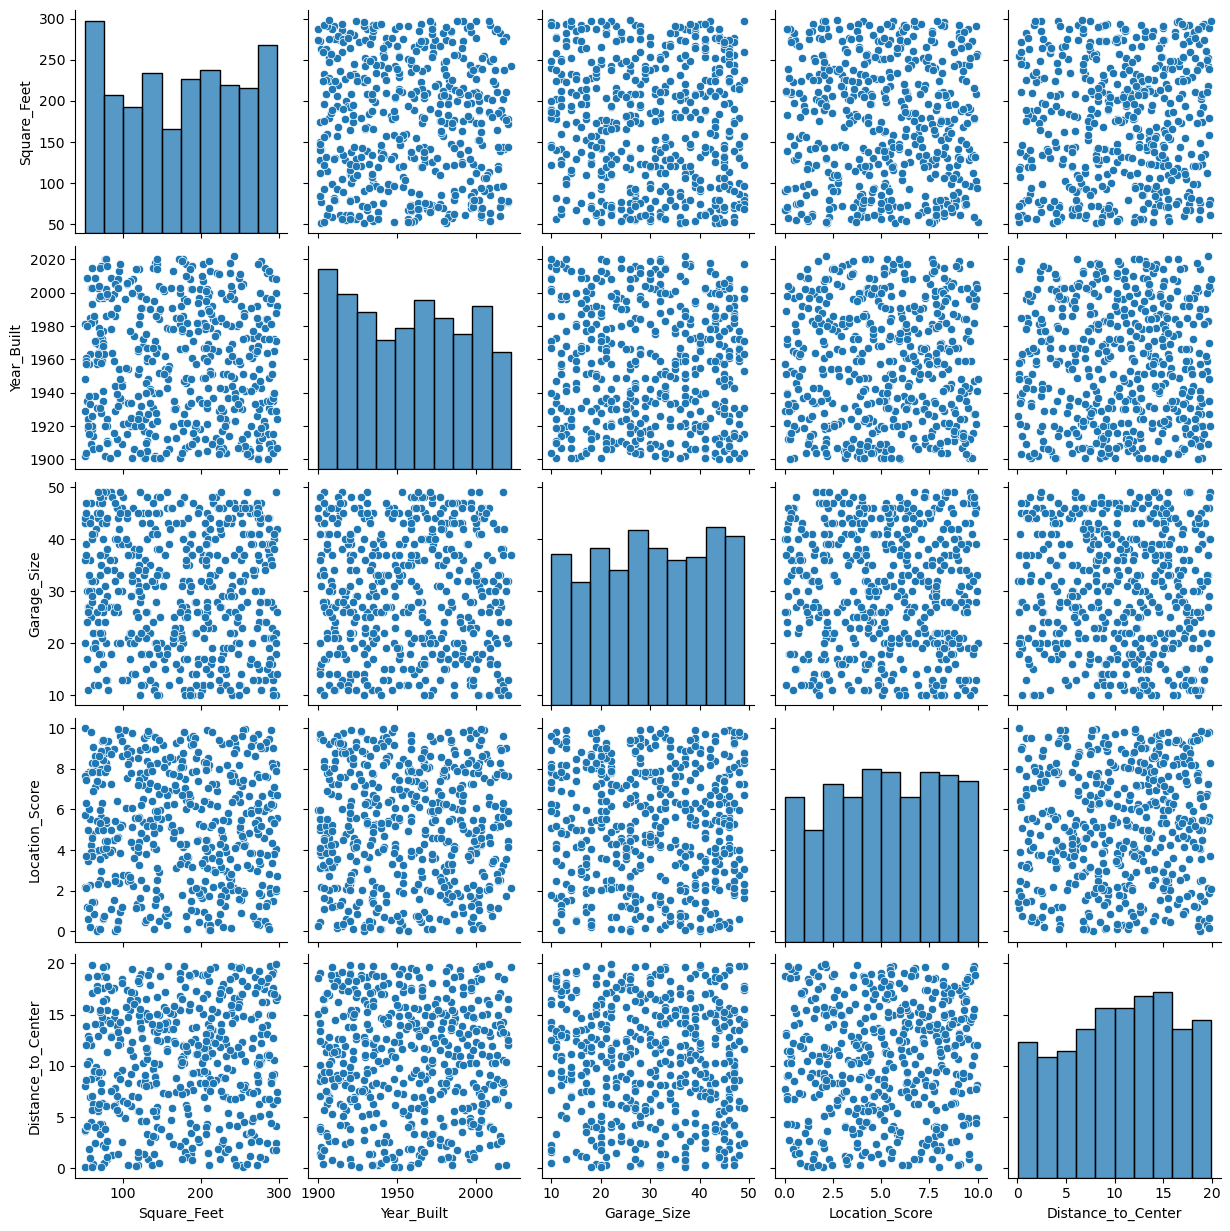

In [8]:
cols = ['Square_Feet', 'Year_Built', 'Garage_Size', 'Location_Score', 'Distance_to_Center']
sns_plot = sns.pairplot(df[cols])
sns_plot.savefig('pairplot.png')

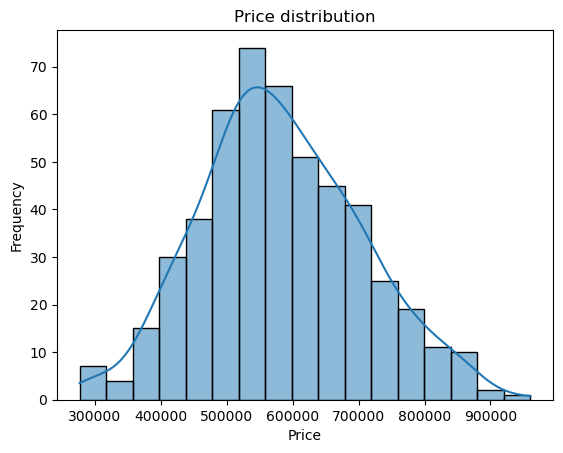

In [9]:
sns.histplot(df['Price'], kde=True)  
plt.title("Price distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

- Let's check the presence of correlated parameters

<Axes: >

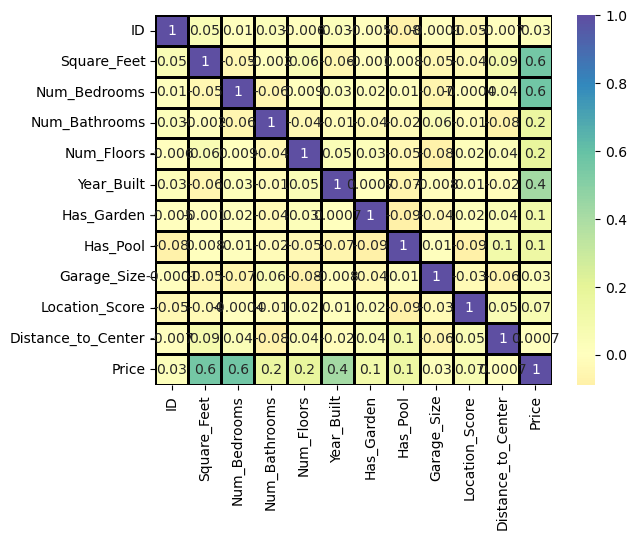

In [10]:
sns.heatmap(df.corr(), annot = True, fmt='.1g', vmax=1, center= 0, cmap= 'Spectral', linewidths=1, linecolor='black')

- Check for duplicates

In [11]:
num_duplicates = df.duplicated().sum()
print(f"Count of duplicates: {num_duplicates}")

Count of duplicates: 0


- Let's check the presence of emissions with a box-plot plot

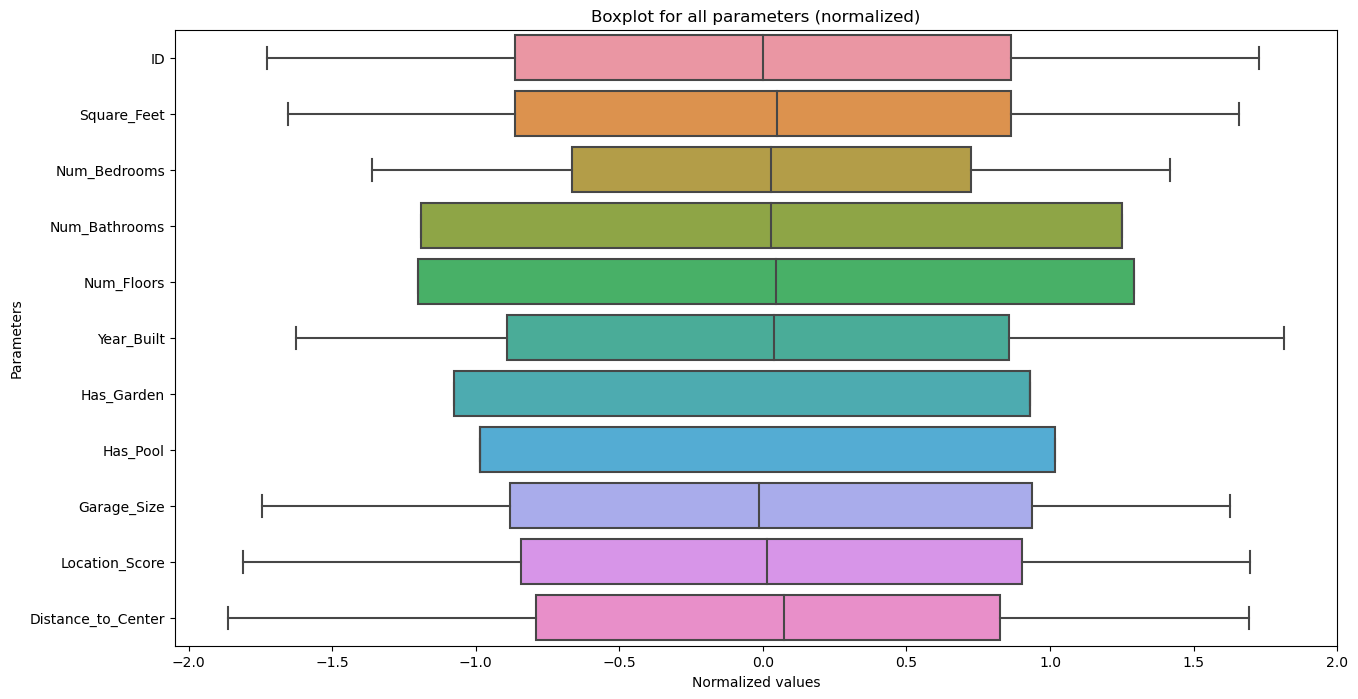

In [12]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df.drop(columns=['Price']))
scaled_df = pd.DataFrame(scaled_data, columns=df.columns.drop('Price'))
plt.figure(figsize=(15, 8))
sns.boxplot(data=scaled_df, orient='h')
plt.title("Boxplot for all parameters (normalized)")
plt.xlabel("Normalized values")
plt.ylabel("Parameters")
plt.show()

```
Based on the above small analysis of the data, we can see that the data has no outliers, duplicates, zeros, correlation. 

This means that with a clear conscience we can move on!
```

# Machine learning

## & Features Importance


I'll try to use for methods:
```
1. Random Forest
2. CatBoost
3. K-NN
4. XGB
```

In [13]:
X = df.drop(['ID', 'Price'], axis = 1)
y = df['Price']

In [14]:
feature_names = X.columns

In [15]:
scaler = StandardScaler()

X = scaler.fit_transform(X)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.35, random_state=250) 

## Random Forest

In [17]:
reg_forest = RandomForestRegressor()

parametrs_fr = {'max_depth':[3, 5],
              'n_estimators':[10, 100, 200],
              'max_features':[1, 3, 5, 7]}

grid_search_reg_forest3 = GridSearchCV(reg_forest, parametrs_fr, cv = 5)

# Обучим на тренировочных данных.
grid_search_reg_forest3.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [3, 5], 'max_features': [1, 3, 5, 7],
                         'n_estimators': [10, 100, 200]})

In [18]:
grid_search_reg_forest3.best_params_

{'max_depth': 5, 'max_features': 7, 'n_estimators': 200}

In [19]:
best_rf_reg3 = grid_search_reg_forest3.best_estimator_

In [20]:
print('Score on train data = ', round(best_rf_reg3.score(X_train, y_train), 4))
print('Score on test data = ', round(best_rf_reg3.score(X_test, y_test), 4))

Score on train data =  0.9095
Score on test data =  0.8086


In [21]:
y_test_pred = best_rf_reg3.predict(X_test)

In [22]:
mae_test = mean_absolute_error(y_test, y_test_pred)
print('MAE on test data =', round(mae_test, 4))

MAE on test data = 44320.0261


In [23]:
best_rf_reg3.feature_importances_

array([0.40410614, 0.32992589, 0.01293234, 0.00923182, 0.17992836,
       0.00280692, 0.00862096, 0.01387584, 0.02122854, 0.01734319])

In [24]:
feature_importances2 = best_rf_reg3.feature_importances_

In [25]:
feature_importances_df2 = pd.DataFrame({'features': feature_names,
                                       'feature_importances': feature_importances2})
feature_importances_df2.sort_values('feature_importances', ascending=0)

,features,feature_importances
0,Square_Feet,0.404106
1,Num_Bedrooms,0.329926
4,Year_Built,0.179928
8,Location_Score,0.021229
9,Distance_to_Center,0.017343
7,Garage_Size,0.013876
2,Num_Bathrooms,0.012932
3,Num_Floors,0.009232
6,Has_Pool,0.008621
5,Has_Garden,0.002807


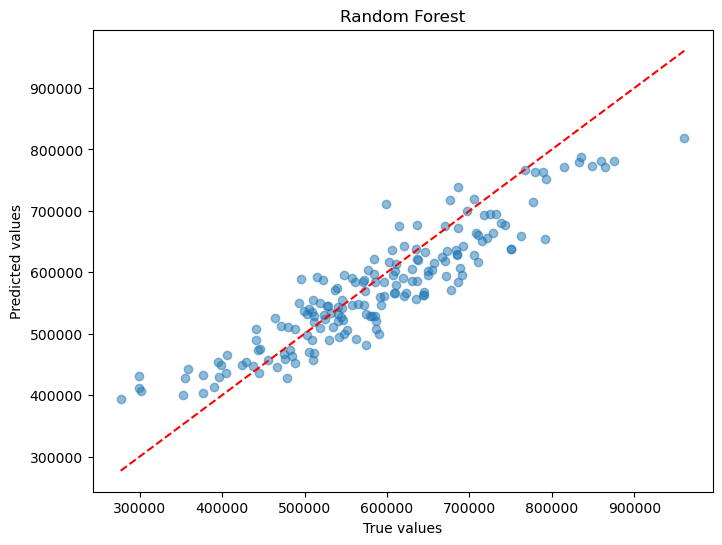

In [26]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--') 
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Random Forest')
plt.show()

## CatBoost

In [27]:
catboost_regressor = CatBoostRegressor(loss_function='MAE', silent=True)

param_catboost = {
    'iterations': [150, 300],
    'learning_rate': [0.1, 0.2],
    'depth': [5, 10],
    'l2_leaf_reg': [1, 3, 5]
}

grid_search_catboost = GridSearchCV(catboost_regressor, param_catboost, cv=3)

grid_search_catboost.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x0000022015998350>,
             param_grid={'depth': [5, 10], 'iterations': [150, 300],
                         'l2_leaf_reg': [1, 3, 5],
                         'learning_rate': [0.1, 0.2]})

In [28]:
grid_search_catboost.best_params_

{'depth': 5, 'iterations': 300, 'l2_leaf_reg': 3, 'learning_rate': 0.2}

In [29]:
best_gs_catboost = grid_search_catboost.best_estimator_

In [30]:
print('Score on train data = ', round(best_gs_catboost.score(X_train, y_train), 4))
print('Score on test data = ', round(best_gs_catboost.score(X_test, y_test), 4))

Score on train data =  0.9946
Score on test data =  0.9365


In [31]:
y_test_pred2 = best_gs_catboost.predict(X_test)
mae_test = mean_absolute_error(y_test, y_test_pred2)
print('MAE on test data =', round(mae_test, 4))

MAE on test data = 24290.0837


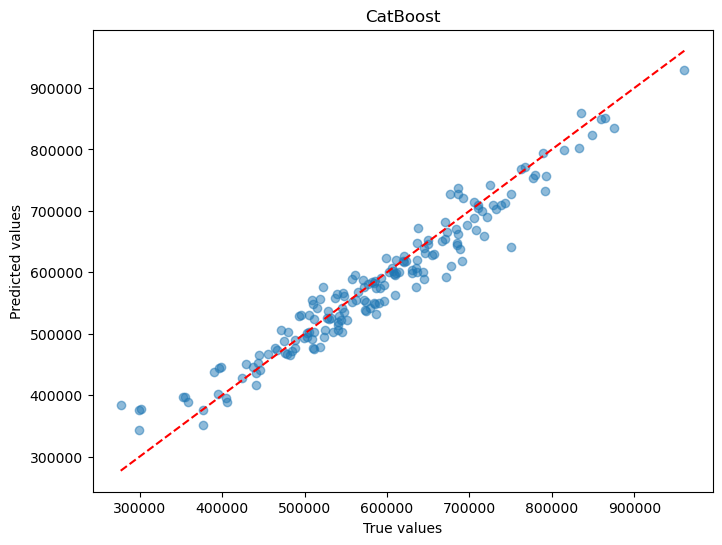

In [32]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred2, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--') 
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('CatBoost')
plt.show()

## K-NN

In [33]:
knn = KNeighborsRegressor()

param_knn = {
    'n_neighbors': range(1, 30),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree'],
    'leaf_size': range(10, 50, 5)}

grid_search_knn2 = GridSearchCV(knn, param_knn, cv=5)
grid_search_knn2.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree'],
                         'leaf_size': range(10, 50, 5),
                         'n_neighbors': range(1, 30),
                         'weights': ['uniform', 'distance']})

In [34]:
grid_search_knn2.best_params_

{'algorithm': 'auto',
 'leaf_size': 10,
 'n_neighbors': 10,
 'weights': 'distance'}

In [35]:
# Сохраним эти параметры в новую переменную, чтобы далее с ними работать
best_gs_knn2 = grid_search_knn2.best_estimator_

In [36]:
print('Score on train data = ', round(best_gs_knn2.score(X_train, y_train), 4))
print('Score on test data = ', round(best_gs_knn2.score(X_test, y_test), 4))

Score on train data =  1.0
Score on test data =  0.7673


In [37]:
y_test_pred3 = best_gs_knn2.predict(X_test)
mae_test = mean_absolute_error(y_test, y_test_pred3)
print('MAE on test data =', round(mae_test, 4))

MAE on test data = 47426.6276


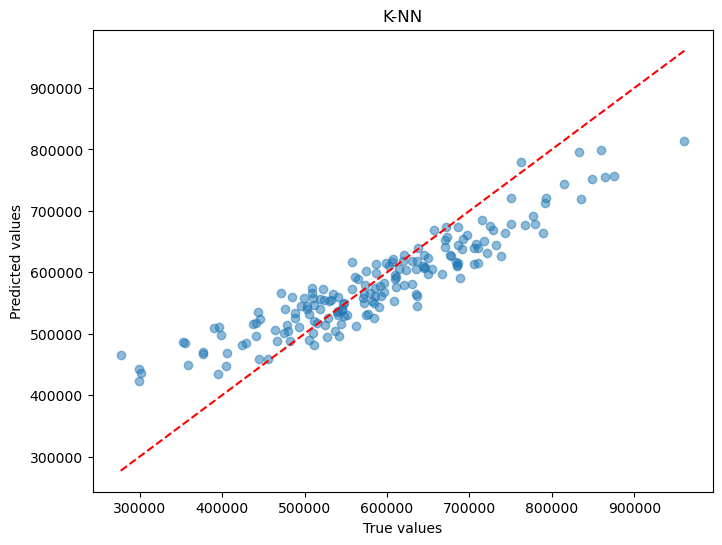

In [38]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred3, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--') 
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('K-NN')
plt.show()

## Extreme Gradient Boosting

In [39]:
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='mae')

# Запишем необходимые нам параметры для дальнейшего перебора.
param_xgb = {
    'n_estimators': [50, 100, 200],  
    'learning_rate': [0.1, 0.2],  
    'max_depth': [3, 5, 10],
    'subsample': [0.8, 1.0],
    'min_child_weight': [1, 3, 5]    
}

# Сделаем перебор заданных выше параметров, при этом разделив выборку данных на 5 частей.
grid_search__xgb = GridSearchCV(xgb_regressor, param_xgb, cv=5)

# Обучим модель на тренировочных данных
grid_search__xgb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric='mae',
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None,...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.2], 'max_depth': [3, 5, 10],
                         'min_child_weight': [1, 3, 5],
                         'n_estimators': [50, 100, 200],
                         'subsample': [0.8, 1.0]})

In [40]:
grid_search__xgb.best_params_

{'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_weight': 5,
 'n_estimators': 200,
 'subsample': 0.8}

In [41]:
best_gs_xgb_two = grid_search__xgb.best_estimator_

In [42]:
print('Score on train data = ', round(best_gs_xgb_two.score(X_train, y_train), 4))
print('Score on test data = ', round(best_gs_xgb_two.score(X_test, y_test), 4))

Score on train data =  0.9955
Score on test data =  0.9414


In [43]:
y_test_pred4 = best_gs_xgb_two.predict(X_test)
mae_test = mean_absolute_error(y_test, y_test_pred4)
print('MAE on test data =', round(mae_test, 4))

MAE on test data = 22647.9422


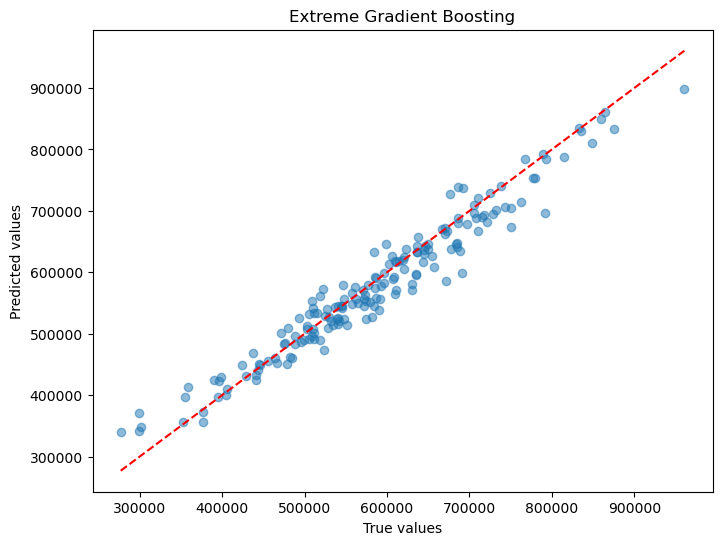

In [44]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred4, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--') 
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Extreme Gradient Boosting')
plt.show()

# Results

In conclusion, I would like to say, that:
```
In the course of this work, data was analyzed and 4 ML models were tested.

The best models is: CatBoost and Extreme Gradient Boosting.
```

This models showed the results:

- CatBoost
```
Score on train data =  0.9946
Score on test data =  0.9365
MAE on test data = 24290.0837
```
- Extreme Gradient Boosting
```
Score on train data =  0.9959
Score on test data =  0.9421
MAE on test data = 23140.3243
```